## Exploratory Data Analysis
Performed by Evan Klein, 11/10/2025

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/application_train.csv')
train.describe()

## There is a lot of data here - we can sample to do some studies without wasting compute or time.
train = train.sample(10_000)

Oh my god, there's a lot of columns. We need to break down what's going on here based on column type.

In [3]:
numerical_columns = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in train.columns if train[col].dtype == 'object']

print(f'Numeric columns: {len(numerical_columns)}')
print(f'Categorical columns: {len(categorical_columns)}')
if len(train.dtypes) == len(numerical_columns) + len(categorical_columns):
    print('All categories accounted for here.')

Numeric columns: 106
Categorical columns: 16
All categories accounted for here.


For our categorical variables, how many distinct values in each?

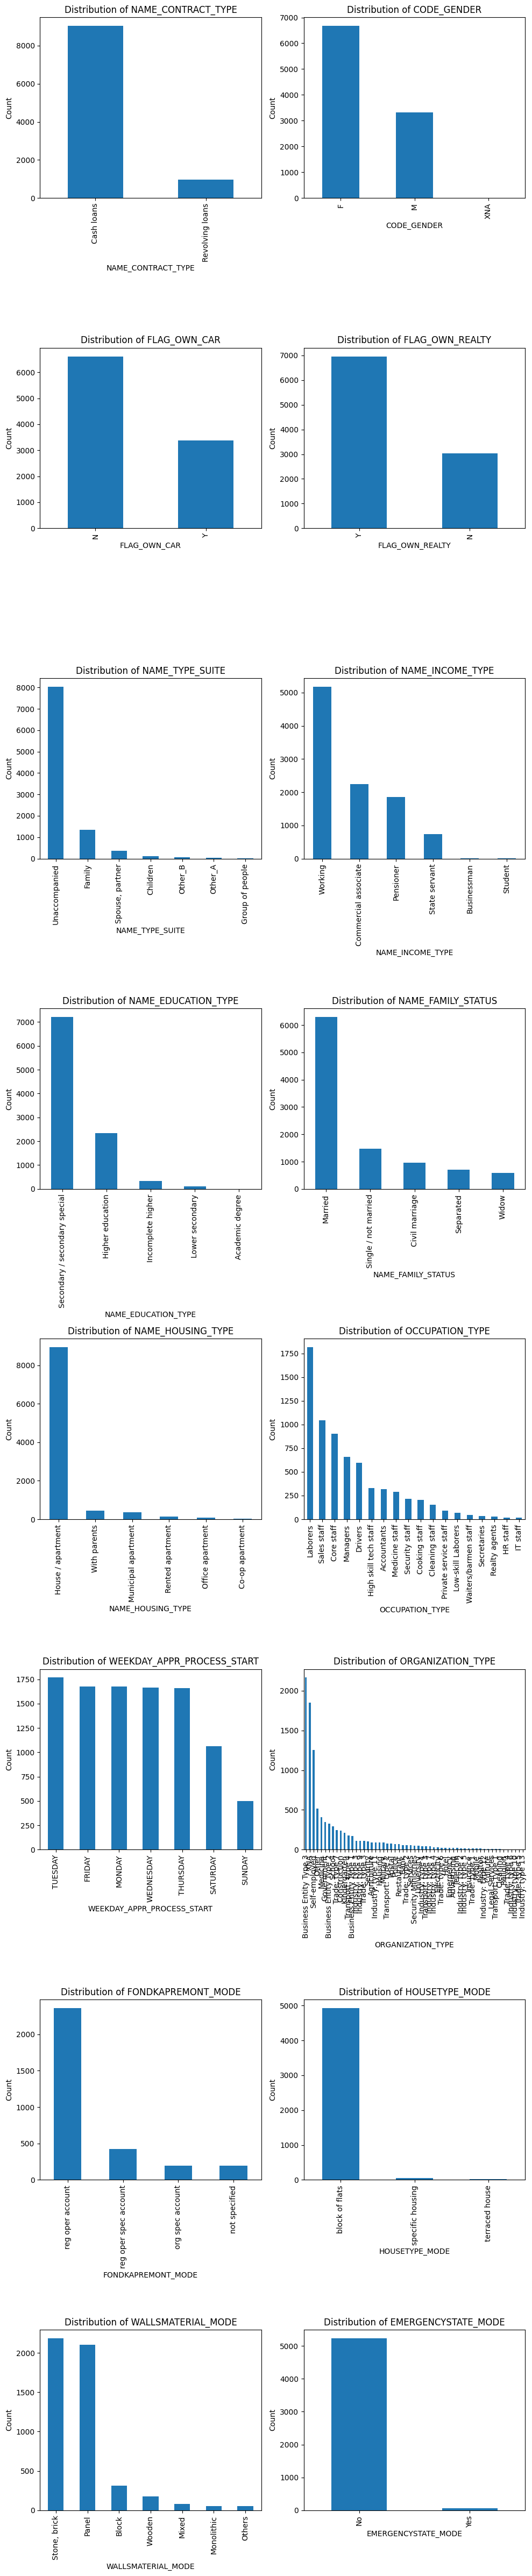

In [4]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(categorical_columns)) / 2), ncols = 2, figsize=(10, 3 * len(categorical_columns)))
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    train[col].value_counts().plot(kind='bar', ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    
plt.tight_layout()
plt.show()


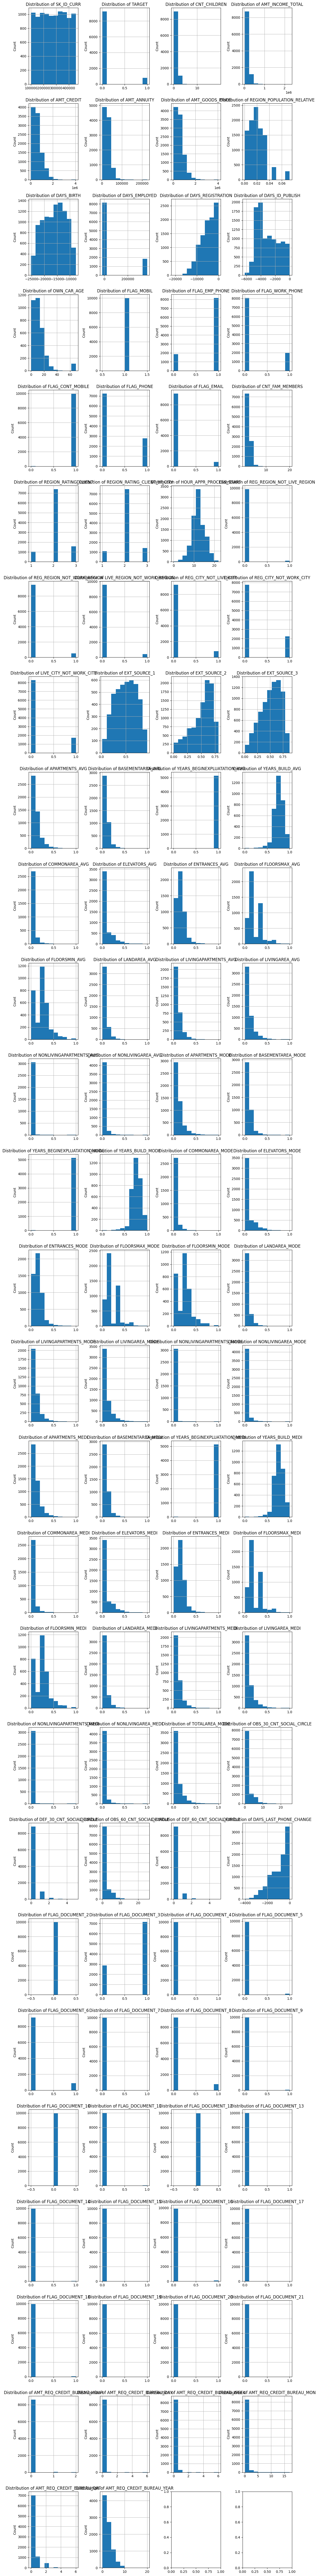

In [5]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(numerical_columns)) / 4) + 1, ncols = 4, figsize=(12, 1 * len(numerical_columns)))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    train[col].hist(ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

We have a good idea of our distributions at this point. Let's cleanup our data and split into $X$, $y$.

In [6]:
y = train['TARGET']
X = train.drop(columns = ['SK_ID_CURR']) # Drop ID, as it's just identifier info on the loan app.

X = pd.get_dummies(X) # Convert categorical variables into OHE.

Now we need to evaluate our dataset for missing variables, which might wreak some havoc later down the line. Handling this now will save us some time later.

In [7]:
X = X.fillna(X.median())

Let's build an understand of correlations within our dataset. We can do this by calculating correlation heatmaps using `seaborn` to build an understand of collinearity within our dataset.

<Axes: >

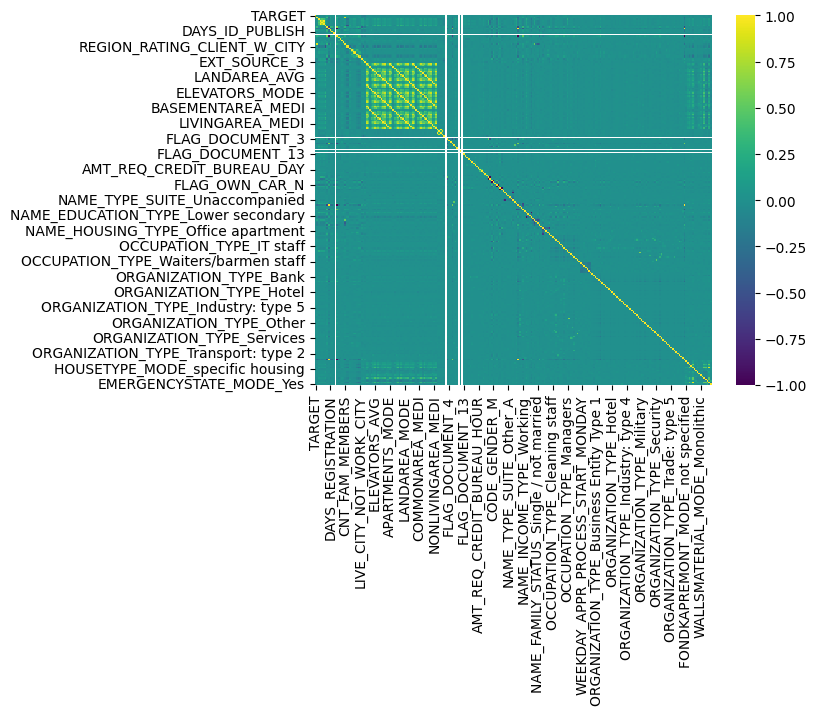

In [8]:
X_corr = X.corr()
sns.heatmap(X_corr, cmap = 'viridis')

We simply have too many variables to study at this point, and this is data from only `application_train.csv`. It doesn't factor in the myriad of data from our additional database tables, such as the ones documenting previous loans, credit history, payment history. Let's work on some methods that will help us visualize the high dimensional data and narrow down the amount of features we need to use.

Before we move onto additional preprocessing, we need to drop `TARGET` from $X$, as it's outlived its usefulness here as part of the initial EDA.

In [9]:
X = X.drop(columns = ['TARGET'])

Perform some standard scaling, as future sections (such as principal component analysis) are going to require nice standardized data.

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)

Let's perform some naive pre-processing, including converting our categorical data to one-hot encoded variants.

### PCA

With so many columns, it might be useful to try to understand how our highly-dimensional data can be better understood and explained. We can study the explained variance and explained variance ratio to understood if our data is truly high-dimensional, or if we can maybe perform some feature engineering as part of our pre-processing steps in order to pare down the large number of features.

Text(0.5, 1.0, 'Explained Variance of Each Principal Component')

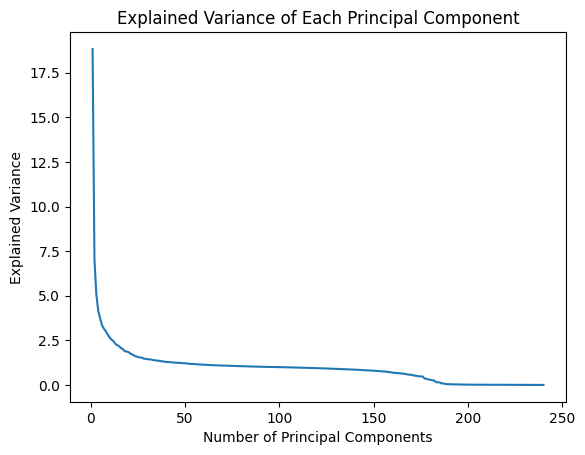

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.ylabel('Explained Variance')
plt.xlabel('Number of Principal Components')
plt.title('Explained Variance of Each Principal Component')

Text(0.5, 1.0, 'Cumulative Sum of Explained Variance')

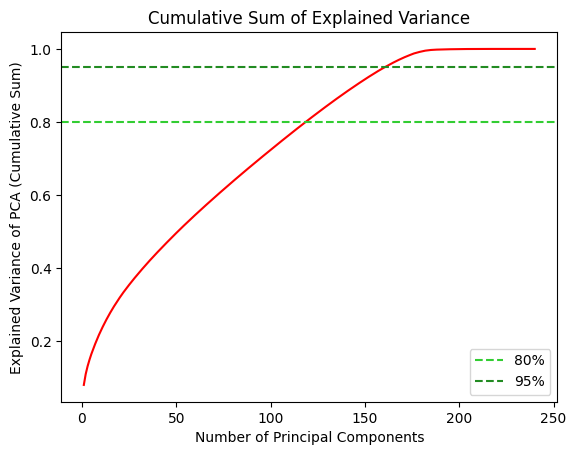

In [12]:
explained_var_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(pca.explained_variance_) + 1), explained_var_cumsum, color = 'red')
plt.axhline(0.8, color = 'limegreen', linestyle = '--', label = '80%')
plt.axhline(0.95, color = 'forestgreen', linestyle = '--', label = '95%')
plt.ylabel('Explained Variance of PCA (Cumulative Sum)')
plt.xlabel('Number of Principal Components')
plt.legend()
plt.title('Cumulative Sum of Explained Variance')

So our data actually is very highly dimensional. Scaling out PCA to the full number of features reveals a very gradual curve, showing us that our target is really probably an aggregate of all features rather than a subset of a few. We can still eliminate a number of features from our model with a very small effect on any created models down the road.

## A round of feature variance removal

Okay, we have too many features still. We need a tradeoff here - we're going to have to lose some features at the risk of making the eventual models less reliable. At this point this is a risk I'm personally willing to take, as I'm willing to bet there's a good amount of features that can be eliminated strictly from a variance standpoint.

In [13]:
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold()
X_reduced = variance_threshold.fit_transform(X_std)
print(f'# of features before: {X_std.shape[1]}, after: {X_reduced.shape[1]}')

# of features before: 240, after: 236


Hm.

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

select_k = SelectKBest(f_classif, k = 5)
X_reduced = select_k.fit_transform(X_std, y)

X_reduced.shape

/Users/evan/GitHub/p556-final/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [11 78 86 88] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/evan/GitHub/p556-final/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(10000, 5)

### t-SNE



In [15]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'pca', perplexity = 35).fit_transform(X_reduced)

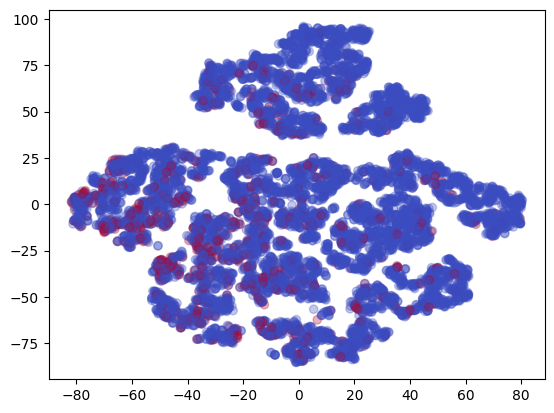

In [16]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y, alpha = 0.3, cmap = 'coolwarm')

### Explore other tables

In [17]:
bureaus = pd.read_csv('data/bureau.csv')
bureaus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [18]:
bureau_balances = pd.read_csv('data/bureau_balance.csv')
bureau_balances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [19]:
previous_apps = pd.read_csv('data/previous_application.csv')
previous_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [20]:
previous_apps.head(20)['NAME_GOODS_CATEGORY']

0                       Mobile
1                          XNA
2                          XNA
3                          XNA
4                          XNA
5                          XNA
6                          XNA
7                          XNA
8                          XNA
9                          XNA
10                         XNA
11                         XNA
12                         XNA
13        Consumer Electronics
14      Construction Materials
15            Auto Accessories
16    Photo / Cinema Equipment
17                         XNA
18                         XNA
19                         XNA
Name: NAME_GOODS_CATEGORY, dtype: object

In [21]:
cash_balances = pd.read_csv('data/POS_CASH_balance.csv')
cash_balances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [22]:
installment_payments = pd.read_csv('data/installments_payments.csv')
installment_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [23]:
credit_card_balances = pd.read_csv('data/credit_card_balance.csv')
credit_card_balances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [24]:
loan_id_to_study = train.iloc[29]['SK_ID_CURR']
loan_id_to_study

np.int64(240156)

In [25]:
bureau_for_loan = bureaus[bureaus['SK_ID_CURR'] == loan_id_to_study]
bureau_for_loan

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1140373,240156,5873385,Closed,currency 1,-1149,0,-770.0,-770.0,0.0,0,206550.0,NaN,NaN,0.0,Consumer credit,-763,NaN


In [26]:
bureau_balances = bureau_balances[bureau_balances['SK_ID_BUREAU'].isin(bureau_for_loan['SK_ID_BUREAU'])]
bureau_balances

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
17095133,5873385,0,C
17095134,5873385,-1,C
17095135,5873385,-2,C
17095136,5873385,-3,C
17095137,5873385,-4,C
17095138,5873385,-5,C
17095139,5873385,-6,C
17095140,5873385,-7,C
17095141,5873385,-8,C
17095142,5873385,-9,C


In [27]:
cash_balances_for_app = cash_balances[cash_balances['SK_ID_CURR'] == loan_id_to_study]
cash_balances_for_app.sort_values(by = 'MONTHS_BALANCE', ascending = False)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
501767,1190594,240156,-1,60.0,49.0,Active,0,0
1130558,1190594,240156,-2,60.0,50.0,Active,0,0
745355,1190594,240156,-3,60.0,51.0,Active,0,0
6046553,1190594,240156,-4,60.0,52.0,Active,0,0
3295362,1190594,240156,-5,60.0,53.0,Active,0,0
...,...,...,...,...,...,...,...,...
8460117,1880853,240156,-93,16.0,11.0,Active,0,0
8461299,1880853,240156,-94,16.0,12.0,Active,0,0
7564184,1880853,240156,-95,16.0,13.0,Active,0,0
8462647,1880853,240156,-96,16.0,14.0,Active,0,0


In [28]:
installments_for_loan = installment_payments[installment_payments['SK_ID_CURR'] == loan_id_to_study]
installments_for_loan.sort_values(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], ascending = False).head(20)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
6041407,2513366,240156,2.0,4,-364.0,-365.0,971144.775,971144.775
5944150,2513366,240156,1.0,3,-394.0,-396.0,44877.420,44877.420
5679271,2513366,240156,1.0,2,-424.0,-475.0,44877.420,44877.420
6971071,2513366,240156,1.0,1,-454.0,-475.0,44877.420,44877.420
4229668,2396679,240156,2.0,4,-481.0,-484.0,184703.670,184703.670
4069315,2396679,240156,1.0,3,-511.0,-517.0,38043.225,38043.225
7353500,2396679,240156,1.0,2,-541.0,-576.0,38043.225,38043.225
5049275,2396679,240156,1.0,1,-571.0,-601.0,38043.225,38043.225
4301156,2379523,240156,2.0,12,-1035.0,-1042.0,20741.130,20741.130
5177637,2379523,240156,1.0,11,-1065.0,-1066.0,20794.275,20794.275


In [29]:
credit_card_balances_for_loan = credit_card_balances[credit_card_balances['SK_ID_CURR'] == loan_id_to_study]
credit_card_balances_for_loan.sort_values(by = 'MONTHS_BALANCE', ascending = False)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF


## Feature engineering ideas

- Aggregate communication-adjacent scores: FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL

### Bureaus
- New feature: `DAYS_CREDIT` mean, show when the last time client requested credit from bureaus
- New feature: `CREDIT_DAY_OVERDUE` across bureaus
- New feature: Build credit utilization for client across each bureau
- New feature: Mean of credit overdue for all bureaus

### Bureau balances
- How many times was client late on a loan from another institution?

### POS Cash Balances
- Get the number of current loans still having payments made on
- Get the number of days past due on all payments and aggregate

### Credit card balances
- Credit utilization for these as well, maybe aggregate it with credit from other bureaus to get overall credit amount, usage, utilization
- Credit balance current

### Installment payments
- \# of times late on any other installments

## PyTorch experimentation

In [30]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
252736,392447,0,Revolving loans,F,N,N,2,58500.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
191844,322454,0,Cash loans,M,N,Y,0,157500.0,152685.0,7794.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
306213,454786,0,Cash loans,F,N,Y,0,180000.0,787131.0,26145.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,6.0
40472,146880,0,Cash loans,F,Y,N,0,112500.0,490536.0,18621.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
150707,274701,0,Cash loans,M,N,Y,0,270000.0,239850.0,23494.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
